In [12]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
import posixpath
import warnings
from pyiron import ase_to_pyiron,pyiron_to_ase
from pyiron import Project
import matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from pyiron.vasp.structure import read_atoms,write_poscar

In [16]:
pr = Project("pyiron/calculation")

In [47]:
pr.pack(destination_path="save")

In [33]:
plt.rcParams.update(
    {'font.size': 24, 'legend.fontsize': 20, 
     'legend.handlelength': 0.5, 'lines.markersize':10,
     'axes.linewidth':2})

In [41]:
ham = pr.load('O_rPBE')
E_O2 = ham.output.energy_tot[-1]


ham_Mg = pr.load('Mg_rPBE')
E_Mg = ham_Mg.output.energy_tot[-1]/2

ham_Ca = pr.load('Ca_rPBE')
E_Ca = ham_Ca.output.energy_tot[-1]

# energy of bulk water
E_H2O = -14.50 

# energy of H2 molecule
E_H2 = -6.98028222

delta_e_Mg_300K = 0.044022583571481366

# Ca surface phase diagram

In [38]:
def calc_ave_energy(job):
    energy = ham.output.energy_tot
    return energy, np.mean(energy), np.std(energy)

In [39]:
job_name_list = ['Mg_water5','Mg_1Ca_water_symm4','Mg_1_3Ca_water6']
#job_name_list = ['Mg_water5','Mg_1Ca_water_symm4','Mg_1_3Ca_water6','dissolve_Ca_4']
label = [r'$\theta = 0$',r'$\theta = 1/12$',r'$\theta = 1/3$','dissolved']
surface_dict = {}
colors = ['C0','C1','C2','C3']
for i, job in enumerate(job_name_list):
    ham = pr.load(job)
    struct = ham.get_structure(-1)
    energy, ave, error = calc_ave_energy(ham)
    surface_dict[job] = {}
    surface_dict[job]['energy'] = energy
    surface_dict[job]['ave_energy'] = ave
    surface_dict[job]['error_energy'] = error
    surface_dict[job]['struct'] = struct    
    cell = struct.cell
    surface_dict[job]['surface_area'] = np.linalg.norm(np.cross(cell[0,:],cell[1,:]))

## vacuum vs implicit vs explicit

In [42]:
kB = 8.617e-5
E_b_0 = 0.09 

def mu_bulk(x, T):
    return E_b_0 + kB*T*np.log(x)

x = np.linspace(1e-10, 1)

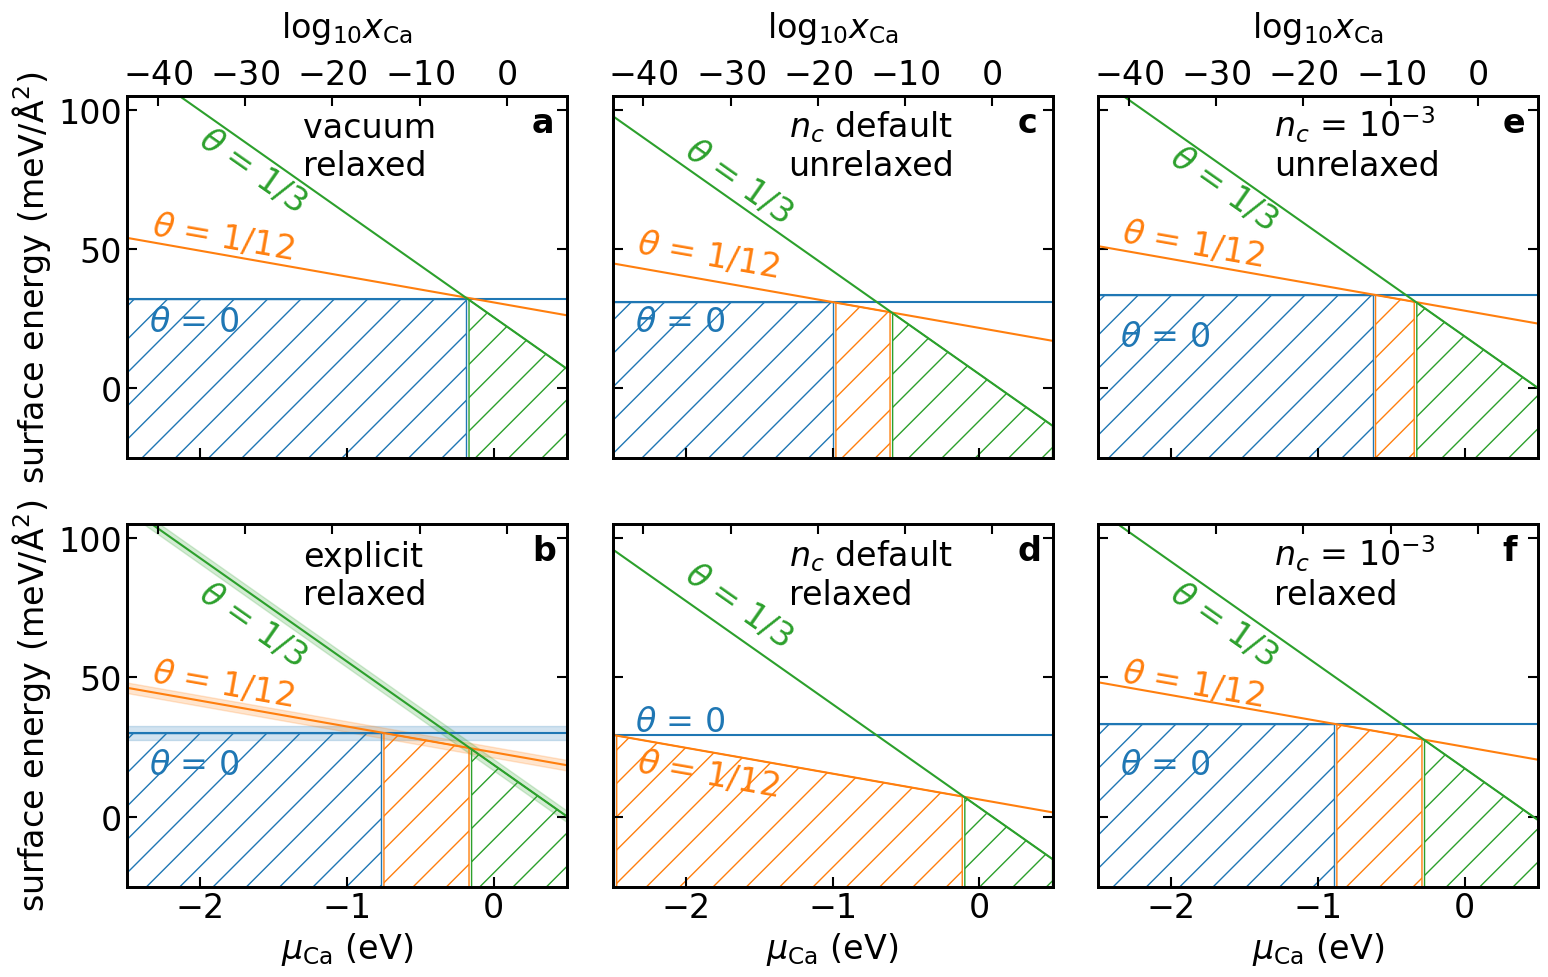

In [43]:
matplotlib.rcParams['text.usetex'] = False
figure, axx = plt.subplots(2,3,facecolor='w', figsize=(16, 10),sharex = True)
labels = [r'$\theta = 0$',r'$\theta = 1/12$',r'$\theta = 1/3$']

mu = {}
mu["O"] = E_O2/2
mu["H"] = (E_H2O - mu["O"])/2
mu["Mg"] = E_Mg 
mu['Ca'] = np.linspace(E_Ca - 3, E_Ca + 0.5, 200)
hatch = '/'

ax = axx[0][0]
job_name_list = ['Mg_surface_relax','Mg_surface_1Ca_relax','Mg_surface_1_3Ca_relax']
surface_dict_implicit = {}
energy_vac_list = []
for i, job in enumerate(job_name_list):
    ham = pr.load(job)
    energy = ham.output.energy_tot[-1]
    surface_dict_implicit[job] = {}
    surface_dict_implicit[job]['energy'] = energy
    surface_dict_implicit[job]['struct'] = ham.get_structure(-1)    
    cell = struct.cell
    surface_dict_implicit[job]['surface_area'] = np.linalg.norm(np.cross(cell[0,:],cell[1,:]))
#labels = ['0','1/12','1/3']
colors = ['C0','C1','C2','C3']
for i, surface in enumerate(surface_dict_implicit.keys()):
    energy = surface_dict_implicit[surface]['energy']
    energy = energy+mu['Ca']-mu['Ca']
    for j, (key, val) in enumerate(surface_dict_implicit[surface]['struct'].get_number_species_atoms().items()):
        energy = energy - mu[key]*val
    energy_vac_list.append(energy*1000/surface_dict_implicit[surface]['surface_area']/2)
    ax.plot(mu['Ca']-E_Ca, energy*1000/surface_dict_implicit[surface]['surface_area']/2, color = colors[i],label = labels[i])

lowest_phase = np.argmin(energy_vac_list, axis = 0)
for i in set(lowest_phase):
    ax.fill_between(mu['Ca']-E_Ca, -60, energy_vac_list[i], where = lowest_phase ==i, 
                    color="none", hatch=hatch, edgecolor= colors[i])


ax = axx[0][1]
job_name_list = ['Mg_surface_vacuum_implicit','Mg_surface_1Ca_vacuum_implicit','Mg_surface_1_3Ca_vacuum_implicit']
surface_dict_implicit = {}
energy_freeze_list = []
for i, job in enumerate(job_name_list):
    ham = pr.load(job)
    energy = ham.output.energy_tot[-1]
    surface_dict_implicit[job] = {}
    surface_dict_implicit[job]['energy'] = energy
    surface_dict_implicit[job]['struct'] = ham.get_structure(-1)    
    cell = struct.cell
    surface_dict_implicit[job]['surface_area'] = np.linalg.norm(np.cross(cell[0,:],cell[1,:]))
#labels = ['0','1/12','1/3']
colors = ['C0','C1','C2','C3']
for i, surface in enumerate(surface_dict_implicit.keys()):
    energy = surface_dict_implicit[surface]['energy']
    energy = energy+mu['Ca']-mu['Ca']
    for j, (key, val) in enumerate(surface_dict_implicit[surface]['struct'].get_number_species_atoms().items()):
        energy = energy - mu[key]*val
    energy_freeze_list.append(energy*1000/surface_dict_implicit[surface]['surface_area']/2)
    ax.plot(mu['Ca']-E_Ca, energy*1000/surface_dict_implicit[surface]['surface_area']/2, color = colors[i],label = labels[i])

lowest_phase = np.argmin(energy_freeze_list, axis = 0)
for i in set(lowest_phase):
    ax.fill_between(mu['Ca']-E_Ca, -60, energy_freeze_list[i], where = lowest_phase ==i, 
                    color="none", hatch=hatch, edgecolor= colors[i])

   
ax = axx[1][1]
job_name_list = ['Mg_surface_implicit_relax', 'Mg_1Ca_implicit_symm_relax','Mg_surface_1_3Ca_implicit_relax']
#job_name_list = ['Mg_surface_implicit_relax', 'Mg_1Ca_implicit_symm_restart','Mg_surface_1_3Ca_implicit_relax']
#job_name_list = ['Mg_implicit_symm_restart','Mg_1Ca_implicit_symm_restart','Mg_1_3Ca_implicit_symm_restart']
surface_dict_implicit = {}
energy_im_list = []
for i, job in enumerate(job_name_list):
    ham = pr.load(job)
    energy = ham.output.energy_tot[-1]
    surface_dict_implicit[job] = {}
    surface_dict_implicit[job]['energy'] = energy
    surface_dict_implicit[job]['struct'] = ham.get_structure(-1)    
    cell = struct.cell
    surface_dict_implicit[job]['surface_area'] = np.linalg.norm(np.cross(cell[0,:],cell[1,:]))

labels = ['0','1/12','1/3']
colors = ['C0','C1','C2','C3']
for i, surface in enumerate(surface_dict_implicit.keys()):
    energy = surface_dict_implicit[surface]['energy']
    energy = energy+mu['Ca']-mu['Ca']
    for j, (key, val) in enumerate(surface_dict_implicit[surface]['struct'].get_number_species_atoms().items()):
        energy = energy - mu[key]*val
    ax.plot(mu['Ca']-E_Ca, energy*1000/surface_dict_implicit[surface]['surface_area']/2, color = colors[i],label = labels[i])
    energy_im_list.append(energy*1000/surface_dict_implicit[surface]['surface_area']/2)
lowest_phase = np.argmin(energy_im_list, axis = 0)
for i in set(lowest_phase):
    ax.fill_between(mu['Ca']-E_Ca, -60, energy_im_list[i], where = lowest_phase ==i, 
                    color="none", hatch=hatch, edgecolor= colors[i])

ax.set_xlabel(r'$\mu_{\rm Ca}$ (eV)')


ax = axx[0][2]
job_name_list = ['Mg_surface_vacuum_implicit','Mg_surface_1Ca_vacuum_implicit','Mg_surface_1_3Ca_vacuum_implicit']
surface_dict_implicit = {}
energy_freeze_list = []
for i, job in enumerate(job_name_list):
    ham = pr.load(job+'_nck0p0009')
    struct = ham.get_structure(-1)
    energy = ham.output.energy_tot[-1]
    surface_dict_implicit[job] = {}
    surface_dict_implicit[job]['energy'] = energy
    surface_dict_implicit[job]['struct'] = struct   
    cell = struct.cell
    surface_dict_implicit[job]['surface_area'] = np.linalg.norm(np.cross(cell[0,:],cell[1,:]))
#labels = ['0','1/12','1/3']
colors = ['C0','C1','C2','C3']
for i, surface in enumerate(surface_dict_implicit.keys()):
    energy = surface_dict_implicit[surface]['energy']
    energy = energy+mu['Ca']-mu['Ca']
    for j, (key, val) in enumerate(surface_dict_implicit[surface]['struct'].get_number_species_atoms().items()):
        energy = energy - mu[key]*val
    energy_freeze_list.append(energy*1000/surface_dict_implicit[surface]['surface_area']/2)
    ax.plot(mu['Ca']-E_Ca, energy*1000/surface_dict_implicit[surface]['surface_area']/2, color = colors[i],label = labels[i])
lowest_phase = np.argmin(energy_freeze_list, axis = 0)
for i in set(lowest_phase):
    ax.fill_between(mu['Ca']-E_Ca, -60, energy_freeze_list[i], where = lowest_phase ==i, 
                    color="none", hatch=hatch, edgecolor= colors[i])



ax = axx[1][2]
job_name_list = ['Mg_surface_vacuum_implicit','Mg_surface_1Ca_vacuum_implicit','Mg_surface_1_3Ca_vacuum_implicit']
surface_dict_implicit = {}
energy_freeze_list = []
for i, job in enumerate(job_name_list):
    ham = pr.load(job+'_nck0p001_relax')#ham = pr.load(job+'_sigma0p4')
    struct = ham.get_structure(-1)
    energy = ham.output.energy_tot[-1]
    surface_dict_implicit[job] = {}
    surface_dict_implicit[job]['energy'] = energy
    surface_dict_implicit[job]['struct'] = struct   
    cell = struct.cell
    surface_dict_implicit[job]['surface_area'] = np.linalg.norm(np.cross(cell[0,:],cell[1,:]))
#labels = ['0','1/12','1/3']
colors = ['C0','C1','C2','C3']
for i, surface in enumerate(surface_dict_implicit.keys()):
    energy = surface_dict_implicit[surface]['energy']
    energy = energy+mu['Ca']-mu['Ca']
    for j, (key, val) in enumerate(surface_dict_implicit[surface]['struct'].get_number_species_atoms().items()):
        energy = energy - mu[key]*val
    energy_freeze_list.append(energy*1000/surface_dict_implicit[surface]['surface_area']/2)
    ax.plot(mu['Ca']-E_Ca, energy*1000/surface_dict_implicit[surface]['surface_area']/2, color = colors[i],label = labels[i])
lowest_phase = np.argmin(energy_freeze_list, axis = 0)
for i in set(lowest_phase):
    ax.fill_between(mu['Ca']-E_Ca, -60, energy_freeze_list[i], where = lowest_phase ==i, 
                    color="none", hatch=hatch, edgecolor= colors[i])
ax.set_xlabel(r'$\mu_{\rm Ca}$ (eV)')



mu["Mg"] = E_Mg + delta_e_Mg_300K
ax = axx[1][0]
labels = ['0','1/12','1/3', 'dissolved']
energy_md_list = []
for i, surface in enumerate(surface_dict.keys()):
    energy = surface_dict[surface]['ave_energy'] + 12*delta_e_Mg_300K # 12 Mg atoms are not allowed to move
    energy = energy+mu['Ca']-mu['Ca']
    for j, (key, val) in enumerate(surface_dict[surface]['struct'].get_number_species_atoms().items()):
        energy = energy - mu[key]*val
    ax.plot(mu['Ca']-E_Ca, energy*1000/surface_dict[surface]['surface_area']/2, color = colors[i],label = labels[i])
    ax.fill_between(mu['Ca']-E_Ca, (energy - surface_dict[surface]['error_energy'])/surface_dict[surface]['surface_area']*1000/2, (energy + surface_dict[surface]['error_energy'])/surface_dict[surface]['surface_area']*1000/2,
                 color=colors[i], alpha=0.2)
    energy_md_list.append(energy*1000/surface_dict[surface]['surface_area']/2)

lowest_phase = np.argmin(energy_md_list, axis = 0)
for i in set(lowest_phase):
    ax.fill_between(mu['Ca']-E_Ca, -60, energy_md_list[i], where = lowest_phase ==i, 
                    color="none", hatch=hatch, edgecolor= colors[i])
    
    

ax.set_xlabel(r'$\mu_{\rm Ca}$ (eV)')

axx[0][0].set_ylabel(r'surface energy (meV/$\mathrm{\AA}^2$)')
axx[1][0].set_ylabel(r'surface energy (meV/$\mathrm{\AA}^2$)')
for ax in axx.flatten():
    #ax.legend(frameon=False)
    ax.set_xlim(-2.5,0.5)
    #ax.set_xlabel(r'$\mu_{\rm Ca}$ (eV)')
    #ax.set_ylim(-60,45)
    ax.tick_params(direction='in',which='major',right='on',top='on',width=1.5,length=7)
    ax.tick_params(direction='in',which='minor',right='on',top='on',width=1.5,length=3,pad=15)
    ax.set_ylim(-25,105)
ax2_list = []
for ax in axx.flatten():    
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2_ticks = np.array([1e-40, 1e-30, 1e-20, 1e-10, 1])
    ax2_tick_positions = mu_bulk(ax2_ticks, 300)
    ax2.set_xticks( ax2_tick_positions )
    ax2.set_xticklabels(['$-$40','$-$30','$-$20','$-$10','0'])

    ax2_list.append(ax2)
    ax2.tick_params(direction='in',which='major',right='on',top='on',width=1.5,length=7)
    ax2.tick_params(direction='in',which='minor',right='on',top='on',width=1.5,length=3)

for ax in [ax2_list[0], ax2_list[1], ax2_list[2]]:
    ax.set_xlabel(r'log$_{10}x_{\rm Ca}$',labelpad = 15)
for ax in [ax2_list[3], ax2_list[4], ax2_list[5]]:
    ax.set_xticklabels([])


    
delta_text = 0.02
text_size = 15
#for ax in [axx[0][0]]:
#    ax.text(-0.202+delta_text, -15, r'$x_{\mathrm{Ca\ in\ Mg}}=10^{-3}$',rotation = 90, size = text_size)
#    ax.text(-0.74+delta_text, -15,r'$c_{\mathrm{Ca}^{2+}}=1\ \times10^{0} {\ \mathrm{ mol/L}}$',rotation = 90, size = text_size)
#    ax.text(-1.2+delta_text, -15, r'$c_{\mathrm{Ca}^{2+}}=8\ \times10^{-8} {\ \mathrm{mol/L}}$',rotation = 90, size = text_size)

for ax in [axx[0][0]]:    
    ax.text(0.05, 0.35, r'$\theta$ = 0',transform=ax.transAxes, color = 'C0')
    ax.text(0.05, 0.55, r'$\theta$ = 1/12', rotation = -10,transform=ax.transAxes, color = 'C1')
    ax.text(0.15, 0.68, r'$\theta$ = 1/3', rotation = -35,transform=ax.transAxes, color = 'C2')
  
for ax in [axx[0][1]]:    
    ax.text(0.05, 0.35, r'$\theta$ = 0',transform=ax.transAxes, color = 'C0')
    ax.text(0.05, 0.5, r'$\theta$ = 1/12', rotation = -10,transform=ax.transAxes, color = 'C1')
    ax.text(0.15, 0.65, r'$\theta$ = 1/3', rotation = -35,transform=ax.transAxes, color = 'C2')
for ax in [axx[1][1]]:    
    ax.text(0.05, 0.43, r'$\theta$ = 0',transform=ax.transAxes, color = 'C0')
    ax.text(0.05, 0.25, r'$\theta$ = 1/12', rotation = -10,transform=ax.transAxes, color = 'C1')
    ax.text(0.15, 0.66, r'$\theta$ = 1/3', rotation = -35,transform=ax.transAxes, color = 'C2')
for ax in [axx[1][0]]:    
    ax.text(0.05, 0.31, r'$\theta$ = 0',transform=ax.transAxes, color = 'C0')
    ax.text(0.05, 0.5, r'$\theta$ = 1/12', rotation = -10,transform=ax.transAxes, color = 'C1')
    ax.text(0.15, 0.61, r'$\theta$ = 1/3', rotation = -35,transform=ax.transAxes, color = 'C2')
for ax in [axx[0][2]]:    
    ax.text(0.05, 0.31, r'$\theta$ = 0',transform=ax.transAxes, color = 'C0')
    ax.text(0.05, 0.53, r'$\theta$ = 1/12', rotation = -10,transform=ax.transAxes, color = 'C1')
    ax.text(0.15, 0.63, r'$\theta$ = 1/3', rotation = -35,transform=ax.transAxes, color = 'C2')
for ax in [axx[1][2]]:    
    ax.text(0.05, 0.31, r'$\theta$ = 0',transform=ax.transAxes, color = 'C0')
    ax.text(0.05, 0.5, r'$\theta$ = 1/12', rotation = -10,transform=ax.transAxes, color = 'C1')
    ax.text(0.15, 0.61, r'$\theta$ = 1/3', rotation = -35,transform=ax.transAxes, color = 'C2')

for ax in [axx[0][1], axx[1][1], axx[0][2], axx[1][2]]:
    ax.set_yticklabels([])
axx[0][0].text(0.4, 0.78,'vacuum\nrelaxed',transform=axx[0][0].transAxes)
axx[0][1].text(0.4, 0.78,"$n_c$ default\nunrelaxed",transform=axx[0][1].transAxes)
axx[1][1].text(0.4, 0.78,"$n_c$ default\nrelaxed",transform=axx[1][1].transAxes)
axx[0][2].text(0.4, 0.78,"$n_c$ = $10^{-3}$\nunrelaxed",transform=axx[0][2].transAxes)
axx[1][2].text(0.4, 0.78,"$n_c$ = $10^{-3}$\nrelaxed",transform=axx[1][2].transAxes)
axx[1][0].text(0.4, 0.78,'explicit\nrelaxed',transform=axx[1][0].transAxes)

axx[0][0].text(0.92,0.9,'a',transform=axx[0][0].transAxes, weight='bold')
axx[1][0].text(0.92,0.9,'b',transform=axx[1][0].transAxes, weight='bold')
axx[0][1].text(0.92,0.9,'c',transform=axx[0][1].transAxes, weight='bold')
axx[1][1].text(0.92,0.9,'d',transform=axx[1][1].transAxes, weight='bold')
axx[0][2].text(0.92,0.9,'e',transform=axx[0][2].transAxes, weight='bold')
axx[1][2].text(0.92,0.9,'f',transform=axx[1][2].transAxes, weight='bold')

figure.tight_layout()
offset = [0, -0.03, 1.0, 1.0]
for ax in axx[1]:
    pos1 = ax.get_position()
    pos2 = [pos1.x0+offset[0],pos1.y0+offset[1],pos1.width*offset[2],pos1.height*offset[3]]
    ax.set_position(pos2)

figure.savefig('surface_energies_Ca')

# H and OH surface phase diagram

In [44]:
pH = np.arange(0,14)
U = 0 
delta_G_H2O = -2.46
k_b = 8.6173324E-5
T = 300

mu = {"Mg":E_Mg}
mu["H"] = E_H2/2 + U - k_b*T*np.log(10*pH)
mu["O"] = E_H2O - 2*mu["H"]
mu["Ca"] = E_Ca



/tmp/ipykernel_10666/1870774370.py:8: RuntimeWarning: divide by zero encountered in log
  mu["H"] = E_H2/2 + U - k_b*T*np.log(10*pH)


## explicit

In [45]:
job_name_list = ['Mg_water5','Mg_water_1_6_OHsymm4','Mg_water_1_3_OHsymm4'
                 ,'Mg_water_1_6_Hsymm5','Mg_water_1_3_Hsymm6']
surface_dict = {}
colors = ['C0','C1','C2','C3','C4','C5','C6']
for i, job in enumerate(job_name_list):
    ham = pr.load(job)
    struct = ham.get_structure(-1)
    energy, ave, error = calc_ave_energy(ham)
    surface_dict[job] = {}
    surface_dict[job]['energy'] = energy
    surface_dict[job]['ave_energy'] = ave
    surface_dict[job]['error_energy'] = error
    surface_dict[job]['struct'] = struct    
    cell = struct.cell
    surface_dict[job]['surface_area'] = np.linalg.norm(np.cross(cell[0,:],cell[1,:]))

## vacuum vs implicit vs explicit

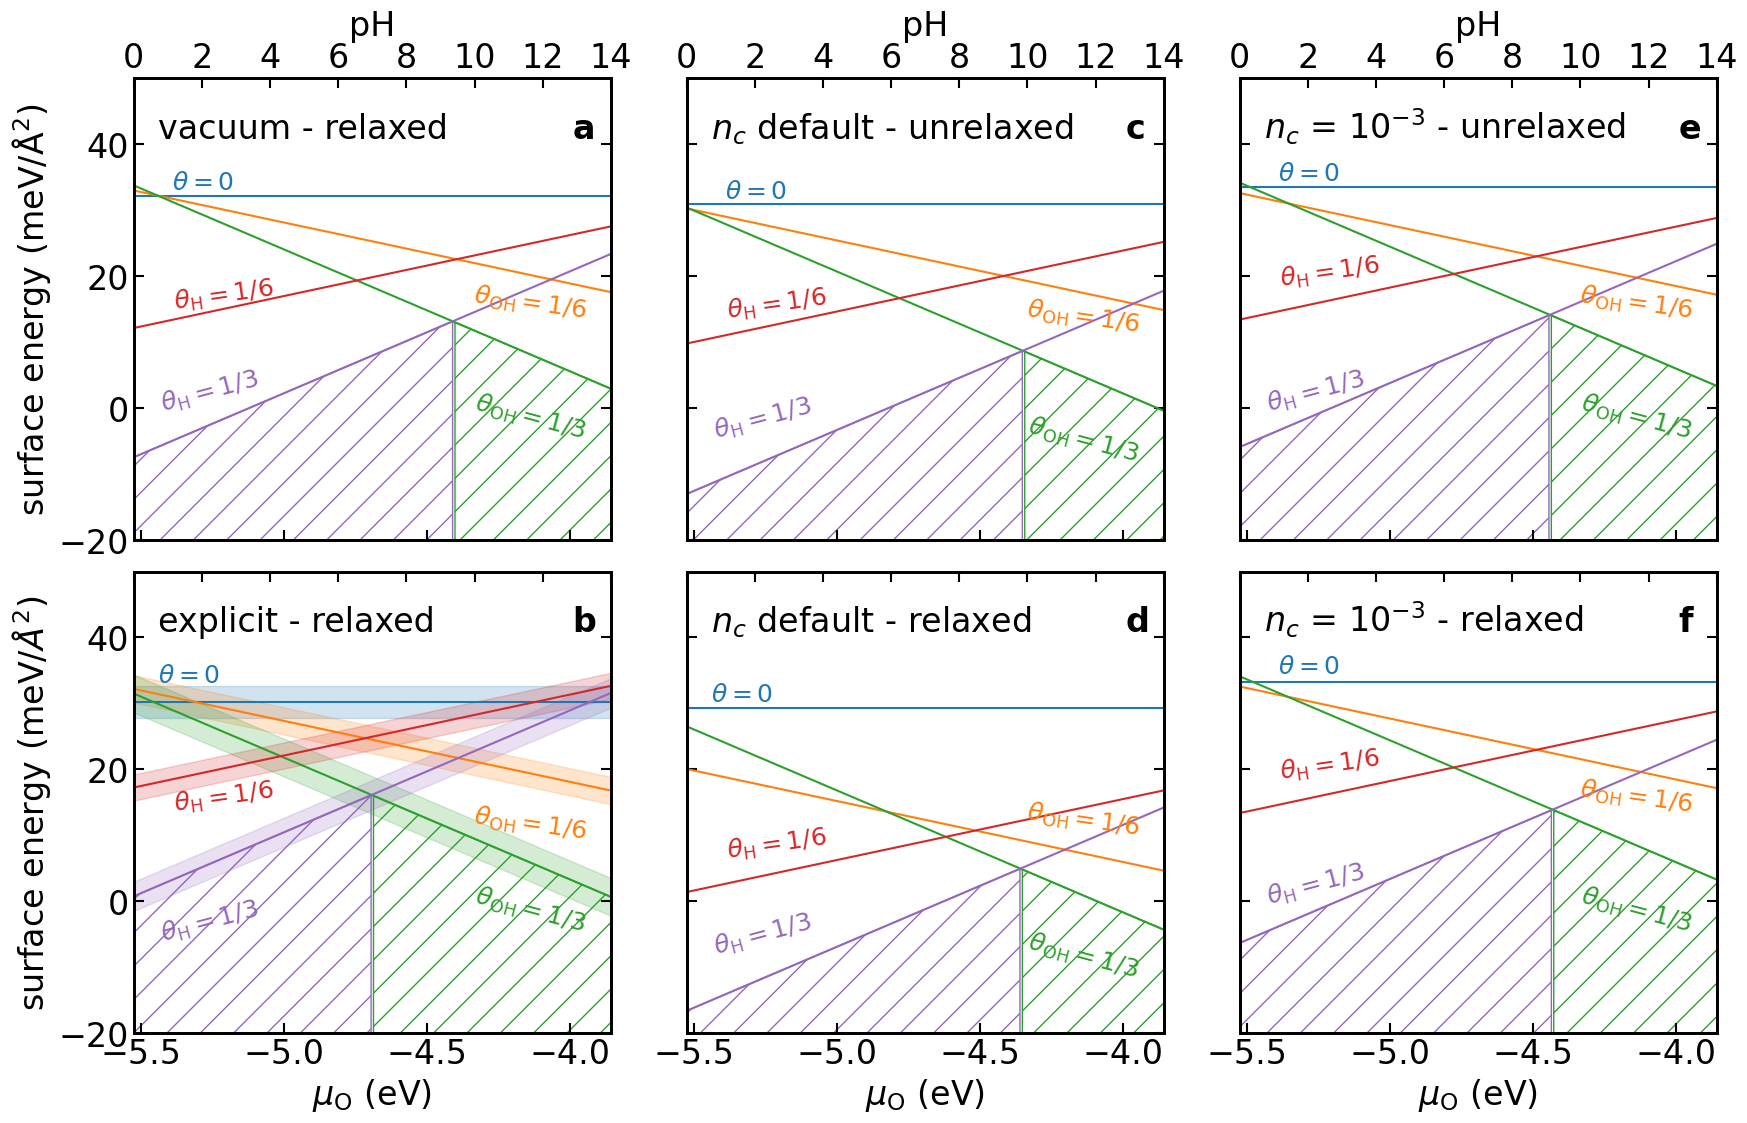

In [46]:
figure, axx = plt.subplots(2,3, facecolor='w', figsize=(18, 12))
mu = {}
mu['Ca'] = E_Ca #np.linspace(E_Ca - 1.5, E_Ca+2)
mu["Mg"] = E_Mg
#mu["O"] = np.linspace(-10.4013716225,-4.169956522499999)
#mu["H"] = (E_H2O - mu["O"])/2
hatch = '/'
pH = np.linspace(0,14, num = 200)
U = -1.115 #0.8 #0.8 #-2.51 #0.8
# U_SHE = -4.73
delta_G_H2O = -2.46 # #
k_b = 8.6173324E-5
T = 300
#mu["O"] = (E_O2)/2 - 2*(U - k_b*T*np.log(10*pH))
#mu["H"] =   (E_H2O - mu["O"])/2  #(E_H2)/2 + U - k_b*T*np.log(10*pH)

#mu["O"] = np.linspace(-14,0)
#mu["H"] =   (E_H2O - mu["O"])/2

mu["H"] = E_H2/2 - U - k_b*T*np.log(10)*pH #+ 0.75
mu["O"] = E_H2O - 2*mu["H"]

ax = axx[0][0]
job_name_list = ['Mg_surface_relax','Mg_1_6OH_vacuum',
                 'Mg_1_3OH_vacuum',
                    'Mg_1_6H_vacuum',
                 'Mg_1_3H_vacuum']

surface_dict_implicit = {}
energy_vac_list = []
for i, job in enumerate(job_name_list):
    ham = pr.load(job)
    energy = ham.output.energy_tot[-1]
    surface_dict_implicit[job] = {}
    surface_dict_implicit[job]['energy'] = energy
    surface_dict_implicit[job]['struct'] = ham.get_structure(-1)    
    cell = struct.cell
    surface_dict_implicit[job]['surface_area'] = np.linalg.norm(np.cross(cell[0,:],cell[1,:]))

labels = ['0','1/6 OH','1/3 OH','1/6 H','1/3 H']
colors = ['C0','C1','C2','C3','C4','C5','C6']
#colors = ['C0','C1','C3','C4','C6']
for i, surface in enumerate(surface_dict_implicit.keys()):
    energy = surface_dict_implicit[surface]['energy']
    energy = energy+mu['O']-mu['O']
    for j, (key, val) in enumerate(surface_dict_implicit[surface]['struct'].get_number_species_atoms().items()):
        energy = energy - mu[key]*val
    ax.plot(mu["O"]-E_O2/2, energy*1000/surface_dict_implicit[surface]['surface_area']/2, color = colors[i],label = labels[i])
    energy_vac_list.append(energy*1000/surface_dict_implicit[surface]['surface_area']/2)
lowest_phase = np.argmin(energy_vac_list, axis = 0)
for i in set(lowest_phase):
    ax.fill_between(mu["O"]-E_O2/2, -60, energy_vac_list[i], where = lowest_phase ==i, 
                    color="none", hatch=hatch, edgecolor= colors[i])

ax.set_xlim(min(mu["O"]-E_O2/2),max(mu["O"]-E_O2/2))
#ax.set_xticklabels([])
ax2 = ax.twiny()
ax2_00 = ax2
ax2.set_xlim(ax.get_xlim())
ax2_ticks = np.array([0,2,4,6,8,10,12,14])
ax2_tick_positions = E_H2O - 2*(E_H2/2 - U - k_b*T*np.log(10)*ax2_ticks)-E_O2/2
ax2.set_xticks( ax2_tick_positions )
ax2.set_xticklabels(['0','2','4','6','8','10','12','14'])
#plt.legend()
#axx.set_xlim(-1.5,2)
#plt.axvline(0, linestyle = '--',color = 'Black')
#ax.set_xlabel('$\mu_{\mathrm{O}}$ (eV)')
ax2.set_xlabel('pH')
ax.set_ylabel(r'surface energy (meV/$\mathrm{\AA}^2$)')




ax = axx[0][1]
job_name_list = ['Mg_surface_vacuum_implicit','Mg_1_6OHimplicit_fixed',
                 'Mg_1_3OHimplicit_fixed',
                    'Mg_1_6Himplicit_fixed',
                 'Mg_1_3Himplicit_fixed']

surface_dict_implicit = {}
energy_freeze_list = [] 
for i, job in enumerate(job_name_list):
    ham = pr.load(job)
    energy = ham.output.energy_tot[-1]
    surface_dict_implicit[job] = {}
    surface_dict_implicit[job]['energy'] = energy
    surface_dict_implicit[job]['struct'] = ham.get_structure(-1)    
    cell = struct.cell
    surface_dict_implicit[job]['surface_area'] = np.linalg.norm(np.cross(cell[0,:],cell[1,:]))

labels = ['0','1/6 OH','1/3 OH','1/6 H','1/3 H']
colors = ['C0','C1','C2','C3','C4','C5','C6']
#colors = ['C0','C1','C3','C4','C6']
for i, surface in enumerate(surface_dict_implicit.keys()):
    energy = surface_dict_implicit[surface]['energy']
    energy = energy+mu['O']-mu['O']
    for j, (key, val) in enumerate(surface_dict_implicit[surface]['struct'].get_number_species_atoms().items()):
        energy = energy - mu[key]*val
    ax.plot(mu["O"]-E_O2/2, energy*1000/surface_dict_implicit[surface]['surface_area']/2, color = colors[i],label = labels[i])
    energy_freeze_list.append(energy*1000/surface_dict_implicit[surface]['surface_area']/2)
lowest_phase = np.argmin(energy_freeze_list, axis = 0)
for i in set(lowest_phase):
    ax.fill_between(mu["O"]-E_O2/2, -60, energy_freeze_list[i], where = lowest_phase ==i, 
                    color="none", hatch=hatch, edgecolor= colors[i])
ax.set_xlim(min(mu["O"]-E_O2/2),max(mu["O"]-E_O2/2))
#ax.set_xticklabels([])
ax2 = ax.twiny()
ax2_01 = ax2
ax2.set_xlim(ax.get_xlim())
ax2_ticks = np.array([0,2,4,6,8,10,12,14])
ax2_tick_positions = E_H2O - 2*(E_H2/2 - U - k_b*T*np.log(10)*ax2_ticks)-E_O2/2
ax2.set_xticks( ax2_tick_positions )
ax2.set_xticklabels(['0','2','4','6','8','10','12','14'])
#plt.legend()
#axx.set_xlim(-1.5,2)
#plt.axvline(0, linestyle = '--',color = 'Black')
#ax.set_xlabel('$\mu_{\mathrm{O}}$ (eV)')
ax2.set_xlabel('pH')


ax = axx[1][1]

#job_name_list = ['Mg_surface_vacuum_implicit','Mg_1OH_implicit_symm_restart','Mg_1_6OH_implicit_symm_restart','Mg_1_3OH_implicit_symm_restart',
#                    'Mg_1H_implicit_symm_restart','Mg_1_6H_implicit_symm_restart','Mg_1_3H_implicit_symm_restart']
#job_name_list = ['Mg_implicit_symm_restart','Mg_1_6OH_implicit_symm_restart','Mg_1_3OH_implicit_symm_restart',
#                    'Mg_1_6H_implicit_symm_restart','Mg_1_3H_implicit_symm_restart']
job_name_list = ['Mg_surface_implicit_relax','Mg_1_6OHimplicit_relaxed','Mg_1_3OHimplicit_relaxed',
                    'Mg_1_6Himplicit_relaxed','Mg_1_3Himplicit_relaxed']
surface_dict_implicit = {}
energy_im_list = []
for i, job in enumerate(job_name_list):
    ham = pr.load(job)
    energy = ham.output.energy_tot[-1]
    surface_dict_implicit[job] = {}
    surface_dict_implicit[job]['energy'] = energy
    surface_dict_implicit[job]['struct'] = ham.get_structure(-1)    
    cell = struct.cell
    surface_dict_implicit[job]['surface_area'] = np.linalg.norm(np.cross(cell[0,:],cell[1,:]))

labels = ['0','1/6 OH','1/3 OH','1/6 H','1/3 H']
colors = ['C0','C1','C2','C3','C4','C5','C6']
#colors = ['C0','C1','C3','C4','C6']
for i, surface in enumerate(surface_dict_implicit.keys()):
    energy = surface_dict_implicit[surface]['energy']
    energy = energy+mu['O']-mu['O']
    for j, (key, val) in enumerate(surface_dict_implicit[surface]['struct'].get_number_species_atoms().items()):
        energy = energy - mu[key]*val
    ax.plot(mu["O"]-E_O2/2, energy*1000/surface_dict_implicit[surface]['surface_area']/2, color = colors[i],label = labels[i])
    energy_im_list.append(energy*1000/surface_dict_implicit[surface]['surface_area']/2)
lowest_phase = np.argmin(energy_im_list, axis = 0)
for i in set(lowest_phase):
    ax.fill_between(mu["O"]-E_O2/2, -60, energy_im_list[i], where = lowest_phase ==i, 
                    color="none", hatch=hatch, edgecolor= colors[i])
ax.set_xlim(min(mu["O"]-E_O2/2),max(mu["O"]-E_O2/2))
#ax.set_xticklabels([])
ax2 = ax.twiny()
ax2_11 = ax2
ax2.set_xlim(ax.get_xlim())
ax2_ticks = np.array([0,2,4,6,8,10,12,14])
ax2_tick_positions = E_H2O - 2*(E_H2/2 - U - k_b*T*np.log(10)*ax2_ticks)-E_O2/2
ax2.set_xticks( ax2_tick_positions )
ax2.set_xticklabels(['0','2','4','6','8','10','12','14'])
#plt.legend()
#axx.set_xlim(-1.5,2)
#plt.axvline(0, linestyle = '--',color = 'Black')
ax.set_xlabel('$\mu_{\mathrm{O}}$ (eV)')
#ax2.set_xlabel('pH')
#ax.set_ylabel(r'surface energy (meV/$\AA^2$)')
#ax.legend()

ax = axx[0][2]

#job_name_list = ['Mg_surface_vacuum_implicit','Mg_1OH_implicit_symm_restart','Mg_1_6OH_implicit_symm_restart','Mg_1_3OH_implicit_symm_restart',
#                    'Mg_1H_implicit_symm_restart','Mg_1_6H_implicit_symm_restart','Mg_1_3H_implicit_symm_restart']
#job_name_list = ['Mg_implicit_symm_restart','Mg_1_6OH_implicit_symm_restart','Mg_1_3OH_implicit_symm_restart',
#                    'Mg_1_6H_implicit_symm_restart','Mg_1_3H_implicit_symm_restart']
job_name_list = ['Mg_surface_vacuum_implicit_nck0p0009', 'Mg_1_6OHimplicit_fixed_nck0p001',
                 'Mg_1_3OHimplicit_fixed_nck0p001',
                    'Mg_1_6Himplicit_fixed_nck0p001',
                 'Mg_1_3Himplicit_fixed_nck0p001']
surface_dict_implicit = {}
energy_im_list = []
for i, job in enumerate(job_name_list):
    ham = pr.load(job)
    energy = ham.output.energy_tot[-1]
    surface_dict_implicit[job] = {}
    surface_dict_implicit[job]['energy'] = energy
    surface_dict_implicit[job]['struct'] = ham.get_structure(-1)    
    cell = struct.cell
    surface_dict_implicit[job]['surface_area'] = np.linalg.norm(np.cross(cell[0,:],cell[1,:]))

labels = ['0','1/6 OH','1/3 OH','1/6 H','1/3 H']
colors = ['C0','C1','C2','C3','C4','C5','C6']
#colors = ['C0','C1','C3','C4','C6']
for i, surface in enumerate(surface_dict_implicit.keys()):
    energy = surface_dict_implicit[surface]['energy']
    energy = energy+mu['O']-mu['O']
    for j, (key, val) in enumerate(surface_dict_implicit[surface]['struct'].get_number_species_atoms().items()):
        energy = energy - mu[key]*val
    ax.plot(mu["O"]-E_O2/2, energy*1000/surface_dict_implicit[surface]['surface_area']/2, color = colors[i],label = labels[i])
    energy_im_list.append(energy*1000/surface_dict_implicit[surface]['surface_area']/2)
lowest_phase = np.argmin(energy_im_list, axis = 0)
for i in set(lowest_phase):
    ax.fill_between(mu["O"]-E_O2/2, -60, energy_im_list[i], where = lowest_phase ==i, 
                    color="none", hatch=hatch, edgecolor= colors[i])
ax.set_xlim(min(mu["O"]-E_O2/2),max(mu["O"]-E_O2/2))
#ax.set_xticklabels([])
ax2 = ax.twiny()
ax2_02 = ax2
ax2.set_xlim(ax.get_xlim())
ax2_ticks = np.array([0,2,4,6,8,10,12,14])
ax2_tick_positions = E_H2O - 2*(E_H2/2 - U - k_b*T*np.log(10)*ax2_ticks)-E_O2/2
ax2.set_xticks( ax2_tick_positions )
ax2.set_xticklabels(['0','2','4','6','8','10','12','14'])
ax2.set_xlabel('pH')


ax = axx[1][2]
job_name_list = ['Mg_surface_vacuum_implicit_nck0p001_relax', 'Mg_1_6OHimplicit_fixed_nck0p001_relax',
                 'Mg_1_3OHimplicit_fixed_nck0p001_relax',
                    'Mg_1_6Himplicit_fixed_nck0p001_relax',
                 'Mg_1_3Himplicit_fixed_nck0p001_relax']
surface_dict_implicit = {}
energy_im_list = []
for i, job in enumerate(job_name_list):
    ham = pr.load(job)
    energy = ham.output.energy_tot[-1]
    surface_dict_implicit[job] = {}
    surface_dict_implicit[job]['energy'] = energy
    surface_dict_implicit[job]['struct'] = ham.get_structure(-1)    
    cell = struct.cell
    surface_dict_implicit[job]['surface_area'] = np.linalg.norm(np.cross(cell[0,:],cell[1,:]))

labels = ['0','1/6 OH','1/3 OH','1/6 H','1/3 H']
colors = ['C0','C1','C2','C3','C4','C5','C6']
#colors = ['C0','C1','C3','C4','C6']
for i, surface in enumerate(surface_dict_implicit.keys()):
    energy = surface_dict_implicit[surface]['energy']
    energy = energy+mu['O']-mu['O']
    for j, (key, val) in enumerate(surface_dict_implicit[surface]['struct'].get_number_species_atoms().items()):
        energy = energy - mu[key]*val
    ax.plot(mu["O"]-E_O2/2, energy*1000/surface_dict_implicit[surface]['surface_area']/2, color = colors[i],label = labels[i])
    energy_im_list.append(energy*1000/surface_dict_implicit[surface]['surface_area']/2)
lowest_phase = np.argmin(energy_im_list, axis = 0)
for i in set(lowest_phase):
    ax.fill_between(mu["O"]-E_O2/2, -60, energy_im_list[i], where = lowest_phase ==i, 
                    color="none", hatch=hatch, edgecolor= colors[i])
ax.set_xlim(min(mu["O"]-E_O2/2),max(mu["O"]-E_O2/2))
#ax.set_xticklabels([])
ax2 = ax.twiny()
ax2_12 = ax2
ax2.set_xlim(ax.get_xlim())
ax2_ticks = np.array([0,2,4,6,8,10,12,14])
ax2_tick_positions = E_H2O - 2*(E_H2/2 - U - k_b*T*np.log(10)*ax2_ticks)-E_O2/2
ax2.set_xticks( ax2_tick_positions )
ax2.set_xticklabels(['0','2','4','6','8','10','12','14'])
ax.set_xlabel('$\mu_{\mathrm{O}}$ (eV)')


mu["Mg"] = E_Mg + delta_e_Mg_300K
energy_md_list = []
ax = axx[1][0]
for i, surface in enumerate(surface_dict.keys()):
    energy = surface_dict[surface]['ave_energy']+12*delta_e_Mg_300K
    energy = energy+mu['O']-mu['O']
    for j, (key, val) in enumerate(surface_dict[surface]['struct'].get_number_species_atoms().items()):
        energy = energy - mu[key]*val
    ax.plot(mu["O"]-E_O2/2, energy*1000/surface_dict[surface]['surface_area']/2, color = colors[i],label = surface)
    ax.fill_between(mu["O"]-E_O2/2, (energy - surface_dict[surface]['error_energy'])/surface_dict[surface]['surface_area']/2*1000, (energy + surface_dict[surface]['error_energy'])/surface_dict[surface]['surface_area']/2*1000,
                 color=colors[i], alpha=0.2)
    energy_md_list.append(energy*1000/surface_dict[surface]['surface_area']/2)
lowest_phase = np.argmin(energy_md_list, axis = 0)
for i in set(lowest_phase):
    ax.fill_between(mu["O"]-E_O2/2, -60, energy_md_list[i], where = lowest_phase ==i, 
                    color="none", hatch=hatch, edgecolor= colors[i])
    #plt.axhline(ave, linestyle = '--',color = colors[i])
    #plt.fill_between([0,5000],ave-error,ave+error,alpha = 0.2,color = colors[i])  
ax.set_xlim(min(mu["O"]-E_O2/2),max(mu["O"]-E_O2/2))
ax2 = ax.twiny()
ax2_10 = ax2
ax2.set_xlim(ax.get_xlim())
ax2_ticks = np.array([0,2,4,6,8,10,12,14])
ax2_tick_positions = E_H2O - 2*(E_H2/2 - U - k_b*T*np.log(10)*ax2_ticks)-E_O2/2
ax2.set_xticks( ax2_tick_positions )
ax2.set_xticklabels(['0','2','4','6','8','10','12','14'])
#ax2.set_xticklabels([])
#plt.legend()
#axx.set_xlim(-1.5,2)
#plt.axvline(0, linestyle = '--',color = 'Black')
ax.set_xlabel('$\mu_{\mathrm{O}}$ (eV)')
#ax2.set_xlabel('pH')
ax.set_ylabel(r'surface energy (meV/$\AA^2$)')


for ax in axx.flatten():
    ax.tick_params(direction='in',which='major',right='on',width=1.5,length=7)
    ax.tick_params(direction='in',which='minor',right='on',width=1.5,length=3,pad=15)
    ax.set_ylim(-20,50)

for ax in [ax2_00, ax2_10,ax2_01,ax2_11, ax2_02, ax2_12]:
    ax.tick_params(direction='in',which='major',right='on',top='on',width=1.5,length=7)
    ax.tick_params(direction='in',which='minor',right='on',top='on',width=1.5,length=3,pad=15)
    
axx[0][0].text(0.05,0.87,'vacuum - relaxed',transform=axx[0][0].transAxes)
axx[1][0].text(0.05,0.87,'explicit - relaxed',transform=axx[1][0].transAxes)
axx[0][1].text(0.05,0.87,'$n_c$ default - unrelaxed',transform=axx[0][1].transAxes)
axx[1][1].text(0.05,0.87,'$n_c$ default - relaxed',transform=axx[1][1].transAxes)
axx[0][2].text(0.05,0.87,r'$n_c$ = $10^{-3}$ - unrelaxed',transform=axx[0][2].transAxes)
axx[1][2].text(0.05,0.87,r'$n_c$ = $10^{-3}$ - relaxed',transform=axx[1][2].transAxes)


axx[0][0].text(0.92, 0.87,'a',transform=axx[0][0].transAxes, weight='bold')
axx[1][0].text(0.92, 0.87,'b',transform=axx[1][0].transAxes, weight='bold')
axx[0][1].text(0.92, 0.87,'c',transform=axx[0][1].transAxes, weight='bold')
axx[1][1].text(0.92, 0.87,'d',transform=axx[1][1].transAxes, weight='bold')
axx[0][2].text(0.92, 0.87,'e',transform=axx[0][2].transAxes, weight='bold')
axx[1][2].text(0.92, 0.87,'f',transform=axx[1][2].transAxes, weight='bold')


for ax in axx[0]:
    ax.set_xticklabels([])
for ax in [ax2_10,ax2_11,ax2_12]:
    ax.set_xticklabels([])

for ax in [axx[0][0]]:
    ax.text(0.08,0.76,r'$\theta = 0$', color = 'C0',transform=ax.transAxes,fontsize = 18)
    ax.text(0.71,0.48,r'$\theta_\mathrm{OH} = 1/6$', rotation = -8, color = 'C1',transform=ax.transAxes,fontsize = 18)
    ax.text(0.71,0.22,r'$\theta_\mathrm{OH} = 1/3$', rotation = -15, color = 'C2',transform=ax.transAxes,fontsize = 18)
    ax.text(0.08,0.5,r'$\theta_\mathrm{H} = 1/6$', rotation = 8, color = 'C3',transform=ax.transAxes,fontsize = 18)
    ax.text(0.05,0.28,r'$\theta_\mathrm{H} = 1/3$', rotation =15, color = 'C4',transform=ax.transAxes,fontsize = 18)

for ax in [axx[0][1]]:
    ax.text(0.08,0.74,r'$\theta = 0$', color = 'C0',transform=ax.transAxes,fontsize = 18)
    ax.text(0.71,0.45,r'$\theta_\mathrm{OH} = 1/6$', rotation = -8, color = 'C1',transform=ax.transAxes,fontsize = 18)
    ax.text(0.71,0.17,r'$\theta_\mathrm{OH} = 1/3$', rotation = -15, color = 'C2',transform=ax.transAxes,fontsize = 18)
    ax.text(0.08,0.48,r'$\theta_\mathrm{H} = 1/6$', rotation = 8, color = 'C3',transform=ax.transAxes,fontsize = 18)
    ax.text(0.05,0.22,r'$\theta_\mathrm{H} = 1/3$', rotation =15, color = 'C4',transform=ax.transAxes,fontsize = 18)

for ax in [axx[1][1]]:
    ax.text(0.05,0.72,r'$\theta = 0$', color = 'C0',transform=ax.transAxes,fontsize = 18)
    ax.text(0.71,0.43,r'$\theta_\mathrm{OH} = 1/6$', rotation = -8, color = 'C1',transform=ax.transAxes,fontsize = 18)
    ax.text(0.71,0.12,r'$\theta_\mathrm{OH} = 1/3$', rotation = -15, color = 'C2',transform=ax.transAxes,fontsize = 18)
    ax.text(0.08,0.38,r'$\theta_\mathrm{H} = 1/6$', rotation = 8, color = 'C3',transform=ax.transAxes,fontsize = 18)
    ax.text(0.05,0.17,r'$\theta_\mathrm{H} = 1/3$', rotation =15, color = 'C4',transform=ax.transAxes,fontsize = 18)


for ax in [axx[1][0]]:
    ax.text(0.05,0.76,r'$\theta = 0$', color = 'C0',transform=ax.transAxes,fontsize = 18)
    ax.text(0.71,0.42,r'$\theta_\mathrm{OH} = 1/6$', rotation = -8, color = 'C1',transform=ax.transAxes,fontsize = 18)
    ax.text(0.71,0.22,r'$\theta_\mathrm{OH} = 1/3$', rotation = -15, color = 'C2',transform=ax.transAxes,fontsize = 18)
    ax.text(0.08,0.48,r'$\theta_\mathrm{H} = 1/6$', rotation = 8, color = 'C3',transform=ax.transAxes,fontsize = 18)
    ax.text(0.05,0.2,r'$\theta_\mathrm{H} = 1/3$', rotation =15, color = 'C4',transform=ax.transAxes,fontsize = 18)

for ax in [axx[0][2], axx[1][2]]:
    ax.text(0.08,0.78,r'$\theta = 0$', color = 'C0',transform=ax.transAxes,fontsize = 18)
    ax.text(0.71,0.48,r'$\theta_\mathrm{OH} = 1/6$', rotation = -8, color = 'C1',transform=ax.transAxes,fontsize = 18)
    ax.text(0.71,0.22,r'$\theta_\mathrm{OH} = 1/3$', rotation = -15, color = 'C2',transform=ax.transAxes,fontsize = 18)
    ax.text(0.08,0.55,r'$\theta_\mathrm{H} = 1/6$', rotation = 8, color = 'C3',transform=ax.transAxes,fontsize = 18)
    ax.text(0.05,0.28,r'$\theta_\mathrm{H} = 1/3$', rotation =15, color = 'C4',transform=ax.transAxes,fontsize = 18)

for ax in [axx[0][1], axx[1][1], axx[0][2], axx[1][2]]:
    ax.set_yticklabels([])
plt.tight_layout()
offset = [0, 0.02, 1.0, 1.0]
for ax in axx[1]:
    pos1 = ax.get_position()
    pos2 = [pos1.x0+offset[0],pos1.y0+offset[1],pos1.width*offset[2],pos1.height*offset[3]]
    ax.set_position(pos2)

figure.savefig('surface_energy_OH')